<a href="https://colab.research.google.com/github/gedp/Analisis_de_datos_TEA/blob/main/Analisis_de_Datos_ADS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis exploratorio y comparativo de datos por grupos de edad de personas con **Trastorno del Espectro Autista (TEA)** (**ASD**, de sus siglas en Inglés)

**Autor:** Gerlyn Eduardo Duarte
**Fecha:** 2025-04-07
**Descripción:** Este cuaderno carga datos de niños, adolescentes y adultos sobre ASD, realiza limpieza, análisis exploratorio (EDA), comparaciones entre grupos y entrena un modelo predictivo básico. Diseñado para cumplir con los requisitos del Bootcamp de Análisis de Datos y visualizar los resultados directamente.

## PASO 1: CONFIGURACIÓN DEL ENTORNO Y CARGA DE DATOS

### 1.1 Importación de Librerías

Importamos las herramientas necesarias:
* `pandas`: Para manipulación de datos tabulares (DataFrames).
* `numpy`: Para operaciones numéricas.
* `matplotlib.pyplot` y `seaborn`: Para crear gráficos estadísticos.
* `plotly.express`: Para crear gráficos interactivos.
* `ydata_profiling`: Para informes de perfilado de datos.
* `scipy.stats`: Para pruebas estadísticas.
* Módulos de `sklearn`: Para el preprocesamiento del modelo, el modelo en sí (Regresión Logística) y la evaluación.

In [ ]:
# Celda de Código 0 (CORREGIDA): Instalación de librerías necesarias respetando dependencias de Colab
!pip install ydata-profiling scikit-learn pandas==2.2.2 -q
# Especificamos la versión exacta de pandas que Colab necesita (pandas==2.2.2)
# y quitamos el --upgrade para pandas para evitar el conflicto.

In [36]:
# Celda de Código 1: Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


### 1.2 Nombres de Archivo y Carga de Datos

**¡IMPORTANTE!** Antes de ejecutar la siguiente celda, asegúrate de haber subido tus 3 archivos CSV (`datos_ninos.csv`, `datos_adolescentes.csv`, `datos_adultos.csv`) al almacenamiento de sesión de Colab usando el panel de Archivos a la izquierda.

Los nombres de archivo definidos a continuación deben coincidir con los que subiste.

In [37]:
# Celda de Código 2: Definir nombres y cargar archivos
archivo_ninos = 'datos_ninos.csv'
archivo_adolescentes = 'datos_adolescentes.csv'
archivo_adultos = 'datos_adultos.csv'

# Función simplificada para cargar (sin Streamlit)
def cargar_y_preparar_datos_colab(nombre_archivo, grupo):
    try:
        df = pd.read_csv(nombre_archivo, sep=',', quotechar='"')
        df['grupo_edad'] = grupo
        print(f"Archivo '{nombre_archivo}' cargado ({df.shape[0]} filas).")
        return df
    except FileNotFoundError:
        print(f"ERROR CRÍTICO: No se pudo encontrar el archivo CSV: {nombre_archivo}. ¿Lo subiste a Colab?")
        raise # Detiene la ejecución si no se encuentra el archivo
    except Exception as e:
        print(f"Error inesperado al cargar el archivo {nombre_archivo}: {e}")
        raise

df_ninos = cargar_y_preparar_datos_colab(archivo_ninos, 'Niño')
df_adolescentes = cargar_y_preparar_datos_colab(archivo_adolescentes, 'Adolescente')
df_adultos = cargar_y_preparar_datos_colab(archivo_adultos, 'Adulto')

# Concatenar
df_completo = pd.concat([df_ninos, df_adolescentes, df_adultos], ignore_index=True)
print("DataFrames concatenados en 'df_completo'.")

# Verificación Inicial
print("\n--- Primeras 5 filas del DataFrame completo: ---")
display(df_completo.head()) # display() es mejor que print() para DataFrames en Colab

print("\n--- Información general del DataFrame completo: ---")
df_completo.info()

print(f"\nDimensiones del DataFrame completo (filas, columnas): {df_completo.shape}")

Archivo 'datos_ninos.csv' cargado (292 filas).
Archivo 'datos_adolescentes.csv' cargado (104 filas).
Archivo 'datos_adultos.csv' cargado (704 filas).
DataFrames concatenados en 'df_completo'.

--- Primeras 5 filas del DataFrame completo: ---


,row ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,grupo_edad
0,Row0,1,1,0,0,1,1,0,1,0,...,Others,no,no,Jordan,no,5,4-11 years,Parent,NO,Niño
1,Row1,1,1,0,0,1,1,0,1,0,...,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO,Niño
2,Row2,1,1,0,0,0,1,1,1,0,...,NaN,no,no,Jordan,yes,5,4-11 years,NaN,NO,Niño
3,Row3,0,1,0,0,1,1,0,0,0,...,NaN,yes,no,Jordan,no,4,4-11 years,NaN,NO,Niño
4,Row4,1,1,1,1,1,1,1,1,1,...,Others,yes,no,United States,no,10,4-11 years,Parent,YES,Niño



--- Información general del DataFrame completo: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   row ID           1100 non-null   object 
 1   A1_Score         1100 non-null   int64  
 2   A2_Score         1100 non-null   int64  
 3   A3_Score         1100 non-null   int64  
 4   A4_Score         1100 non-null   int64  
 5   A5_Score         1100 non-null   int64  
 6   A6_Score         1100 non-null   int64  
 7   A7_Score         1100 non-null   int64  
 8   A8_Score         1100 non-null   int64  
 9   A9_Score         1100 non-null   int64  
 10  A10_Score        1100 non-null   int64  
 11  age              1094 non-null   float64
 12  gender           1100 non-null   object 
 13  ethnicity        956 non-null    object 
 14  jundice          1100 non-null   object 
 15  austim           1100 non-null   object 
 16  contry_

## PASO 2: LIMPIEZA Y PREPROCESAMIENTO DE DATOS

Esta es una fase CRÍTICA. Abordaremos valores faltantes, tipos de datos incorrectos, outliers y posibles inconsistencias.

In [ ]:
# Celda de Código 3 (COMPLETA CON DIAGNÓSTICO DE FORMA)
print("\n--- Iniciando Limpieza (Copia, Renombrado/Eliminación Inicial) ---")

# Asegurarnos que df_completo existe antes de copiar
if 'df_completo' in locals() or 'df_completo' in globals():
    print(f"Forma de df_completo ANTES de copiar: {df_completo.shape}") # Verificar df_completo

    # 1. Crear la copia
    df_limpio = df_completo.copy()
    print(f"Forma de df_limpio DESPUÉS de copiar: {df_limpio.shape}") # <<<--- VERIFICAR AQUÍ

    # 2. Renombrar columnas
    try:
        df_limpio.rename(columns={'Class/ASD': 'Class_ASD', 'austim': 'autism_family_hist'}, inplace=True)
        print("Columnas renombradas.")
    except Exception as e:
        print(f"Error durante rename: {e}")
    print(f"Forma de df_limpio DESPUÉS de renombrar: {df_limpio.shape}") # <<<--- VERIFICAR AQUÍ

    # 3. Eliminar 'row ID' si existe
    if 'row ID' in df_limpio.columns:
        try:
            df_limpio.drop(columns=['row ID'], inplace=True)
            print("Columna 'row ID' eliminada.")
        except Exception as e:
            print(f"Error durante drop(row ID): {e}")
    else:
        print("Columna 'row ID' no encontrada, no se eliminó.")

    print(f"Forma de df_limpio DESPUÉS de drop(row ID): {df_limpio.shape}") # <<<--- VERIFICAR AQUÍ

    print("\n--- Fin de la ejecución de Celda 3 ---")
else:
    print("ERROR: df_completo no existe. Ejecuta la Celda 2 primero.")

In [ ]:
# Celda de Código 4 (COMPLETA Y CORREGIDA CON DIAGNÓSTICO DE FORMA)
print("\n--- Manejando Valores Faltantes ---")
print("Valores faltantes por columna ANTES del tratamiento:")
print(df_limpio.isnull().sum())

# --- Diagnóstico ANTES de dropna(age) ---
print(f"\nForma ANTES de dropna(age): {df_limpio.shape}")
print(f"Valores NaN en 'age' ANTES de dropna: {df_limpio['age'].isnull().sum()}")
print(f"Tipo de dato de 'age' ANTES de dropna: {df_limpio['age'].dtype}")
# --- Fin Diagnóstico ---

# Estrategia: Eliminar filas con 'age' faltante
filas_antes_drop_age = df_limpio.shape[0]
df_limpio.dropna(subset=['age'], inplace=True)
filas_despues_drop_age = df_limpio.shape[0]

# --- Diagnóstico DESPUÉS de dropna(age) ---
print(f"\nForma DESPUÉS de dropna(age): {df_limpio.shape}") # <<<--- ¡¡VERIFICAR ESTE NÚMERO!!
print(f"Filas eliminadas por 'age' faltante (según cálculo): {filas_antes_drop_age - filas_despues_drop_age}")
# --- Fin Diagnóstico ---


# Estrategia: Imputar 'ethnicity' y 'relation' con 'Desconocido'
print("\nImputando 'ethnicity' y 'relation'...")
df_limpio['ethnicity'].fillna('Desconocido', inplace=True)
df_limpio['relation'].fillna('Desconocido', inplace=True)
print("Valores faltantes en 'ethnicity' y 'relation' imputados con 'Desconocido'.")

print("\nValores faltantes por columna DESPUÉS del tratamiento completo de Celda 4:")
print(df_limpio.isnull().sum())

In [ ]:
# Celda de Código 5 (COMPLETA Y CORREGIDA v3 - DIAGNÓSTICO Class_ASD)
print("\n--- Corrigiendo Tipos de Datos ---")

# Numéricas a Entero
df_limpio['age'] = df_limpio['age'].astype(int)
score_cols = [f'A{i}_Score' for i in range(1, 11)]
for col in score_cols:
    df_limpio[col] = df_limpio[col].astype(int)
df_limpio['result'] = df_limpio['result'].astype(int)
print("Tipos de datos numéricos ('age', scores, 'result') verificados/convertidos a entero.")

# --- Sección Corregida v2: Convertir yes/no a 1/0 (Más Robusta) ---
print("\n--- Convirtiendo columnas 'yes'/'no' a numérico (1/0) ---")
map_yes_no = {'yes': 1, 'no': 0}
cols_yes_no = ['jundice', 'autism_family_hist', 'used_app_before']

for col in cols_yes_no:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].astype(str)
        df_limpio[col] = df_limpio[col].str.lower()
        df_limpio[col] = df_limpio[col].map(map_yes_no)
        if df_limpio[col].isnull().any():
            moda = df_limpio[col].dropna().mode()
            if not moda.empty:
                moda_value = moda.iloc[0]
                df_limpio[col].fillna(moda_value, inplace=True)
                print(f"Valores no reconocidos ('yes'/'no') en '{col}' fueron imputados con la moda ({moda_value}).")
            else:
                df_limpio[col].fillna(0, inplace=True)
                print(f"Advertencia: No se pudo calcular la moda para '{col}'. Valores no reconocidos imputados con 0.")
        if df_limpio[col].isnull().any():
             print(f"Advertencia: Aún quedan NaNs en la columna {col} antes de convertir a Int64. Imputando con 0.")
             df_limpio[col].fillna(0, inplace=True)
        df_limpio[col] = df_limpio[col].astype('Int64')
        print(f"Columna '{col}' convertida a numérico Int64 (1/0).")
    else:
        print(f"Advertencia: Columna '{col}' no encontrada.")
# --- Fin Sección Corregida v2 ---

# Variable Objetivo (Class_ASD a 1/0) - CON DIAGNÓSTICO Y SIN DROPNA
print("\n--- Procesando 'Class_ASD' (CON DIAGNÓSTICO) ---")
map_asd = {'YES': 1, 'NO': 0}

# ** Diagnóstico Antes del Mapeo **
print("Valores ÚNICOS en 'Class_ASD' ANTES de procesar:")
try:
    print(df_limpio['Class_ASD'].unique())
except Exception as e:
    print(f"No se pudieron mostrar los únicos (puede que la columna no exista aún): {e}")

# Aseguramos que sea string y luego mayúsculas antes de mapear
if 'Class_ASD' in df_limpio.columns:
    df_limpio['Class_ASD_original_str'] = df_limpio['Class_ASD'].astype(str) # Guardamos copia original como string
    df_limpio['Class_ASD'] = df_limpio['Class_ASD_original_str'].str.upper() # Convertimos a Mayúsculas

    print("Valores ÚNICOS en 'Class_ASD' DESPUÉS de .astype(str).str.upper():")
    print(df_limpio['Class_ASD'].unique())

    # Aplicamos el mapeo
    df_limpio['Class_ASD'] = df_limpio['Class_ASD'].map(map_asd) # YES/NO -> 1/0, otros -> NaN

    # ** Diagnóstico Después del Mapeo **
    print("Valores ÚNICOS en 'Class_ASD' DESPUÉS de mapear (YES->1, NO->0, otros->NaN):")
    # Usamos value_counts para ver NaNs también
    print(df_limpio['Class_ASD'].value_counts(dropna=False))

    # Verificamos si hubo NaNs (valores no mapeados)
    nan_count_asd = df_limpio['Class_ASD'].isnull().sum()
    if nan_count_asd > 0:
        print(f"\nADVERTENCIA: Se encontraron {nan_count_asd} valores que no eran 'YES' o 'NO' en 'Class_ASD'.")
        # ---- TEMPORALMENTE COMENTADO PARA DEPURAR ----
        # print("Eliminando las filas con valores inesperados/NaNs en 'Class_ASD'...")
        # df_limpio.dropna(subset=['Class_ASD'], inplace=True)
        # ---- FIN TEMPORALMENTE COMENTADO ----
        print("NOTA DE DEPURACIÓN: La línea dropna para Class_ASD está comentada. Los NaNs permanecerán por ahora.")
        # Convertimos a tipo Float64 que sí soporta NaN, en lugar de Int64 por ahora
        df_limpio['Class_ASD'] = df_limpio['Class_ASD'].astype('Float64')
    else:
         print("Todos los valores en 'Class_ASD' eran 'YES' o 'NO'.")
         # Si no hay NaNs, podemos convertir a Int64
         df_limpio['Class_ASD'] = df_limpio['Class_ASD'].astype('Int64')

    print("Columna 'Class_ASD' procesada.")
else:
    print("Columna 'Class_ASD' no encontrada para procesar.")


# Categóricas a tipo 'category'
print("\n--- Convirtiendo otras categóricas a tipo 'category' ---")
cols_categoricas = ['gender', 'ethnicity', 'contry_of_res', 'age_desc', 'relation', 'grupo_edad']
for col in cols_categoricas:
     if col in df_limpio.columns:
        if df_limpio[col].isnull().any():
             if not pd.api.types.is_string_dtype(df_limpio[col]) and not pd.api.types.is_categorical_dtype(df_limpio[col]):
                  df_limpio[col] = df_limpio[col].astype(str)
             df_limpio[col].fillna('Desconocido', inplace=True)
        df_limpio[col] = df_limpio[col].astype('category')
        print(f"Columna '{col}' convertida a tipo 'category'.")

print("\n--- Tipos de datos después de la corrección (CON Class_ASD NaN si los hubo): ---")
df_limpio.info()

In [ ]:
# Celda de Código 6: Manejo de Outliers (Edad) y Eliminación Final
print("\n--- Manejando Outliers ('age') ---")
edad_maxima_razonable = 100
outliers_edad = df_limpio[df_limpio['age'] > edad_maxima_razonable]
if not outliers_edad.empty:
    print(f"Se encontraron {len(outliers_edad)} outliers de edad (>{edad_maxima_razonable} años). Serán eliminados.")
    display(outliers_edad) # Mostrar los outliers encontrados
    filas_antes_drop_outlier = df_limpio.shape[0]
    df_limpio = df_limpio[df_limpio['age'] <= edad_maxima_razonable]
    filas_despues_drop_outlier = df_limpio.shape[0]
    print(f"\nFilas eliminadas por outlier de edad: {filas_antes_drop_outlier - filas_despues_drop_outlier}")
else:
    print(f"No se encontraron outliers de edad (>{edad_maxima_razonable} años).")

# Eliminar 'age_desc'
if 'age_desc' in df_limpio.columns:
    df_limpio.drop(columns=['age_desc'], inplace=True)
    print("\nColumna 'age_desc' eliminada.")

# Verificación Final
print("\n--- Verificación Final del DataFrame Limpio ---")
print(f"Dimensiones finales: {df_limpio.shape}")
print("Valores faltantes finales:")
print(df_limpio.isnull().sum())
print("\nPrimeras filas del DataFrame limpio final:")
display(df_limpio.head())

## PASO 3: GENERACIÓN DE PERFIL DETALLADO (ydata-profiling)

Utilizamos `ydata-profiling` para obtener un informe HTML interactivo sobre el estado de nuestros datos limpios. Esto puede tardar unos minutos. El informe se mostrará directamente en la salida de la celda.

In [ ]:
# Celda de Código 7: Generar y Mostrar Informe de Profiling
print("\n--- Iniciando Paso 3: Generación de Informe con ydata-profiling ---")
try:
    profile = ProfileReport(df_limpio, title="Informe de Perfilado - Datos ASD", explorative=True, minimal=False)
    print("Informe generado. Mostrando en el notebook...")
    # Mostrar el informe dentro del cuaderno de Colab
    profile.to_notebook_iframe()

    # Opcional: Guardar también como archivo HTML si lo deseas
    # nombre_archivo_reporte = "reporte_profiling_asd.html"
    # profile.to_file(nombre_archivo_reporte)
    # print(f"Informe de ydata-profiling también guardado como '{nombre_archivo_reporte}'.")

except Exception as e:
    print(f"Error al generar o mostrar el informe de ydata-profiling: {e}")

## PASO 4: ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Exploramos los datos visual y numéricamente para entender distribuciones y relaciones. Los gráficos se mostrarán debajo de cada celda.


--- Iniciando Paso 4: Análisis Exploratorio de Datos (EDA) ---
Estilo de gráficos Seaborn configurado.

--- 4.1 Análisis Univariado ---

**Distribución General de Edad**


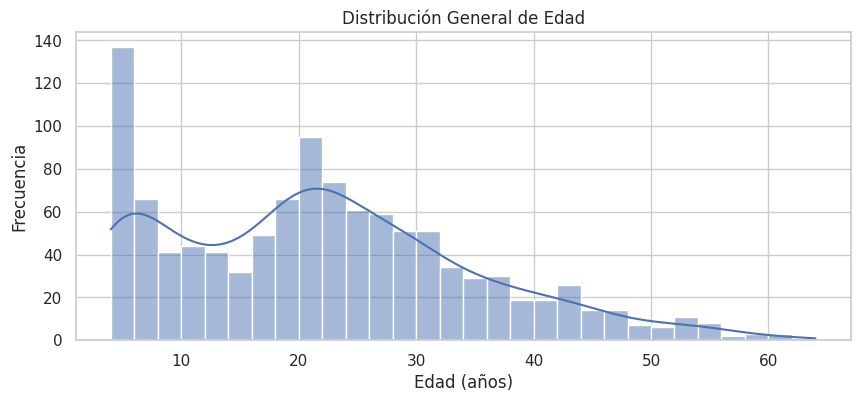


**Distribución de Edad por Grupo**


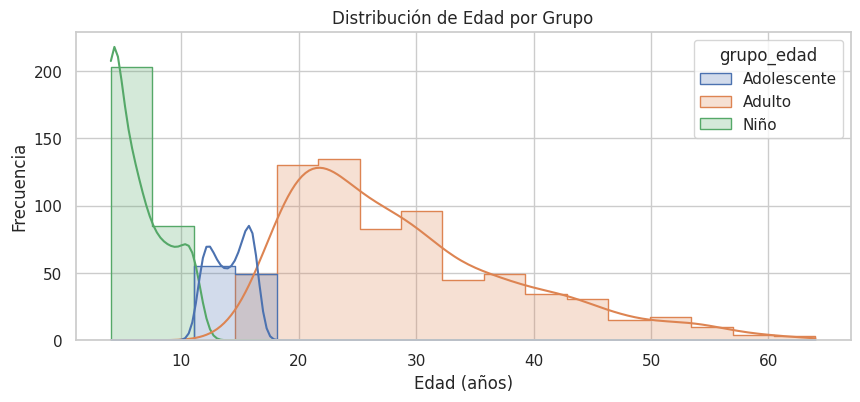


**Distribución de la Puntuación Total (result)**


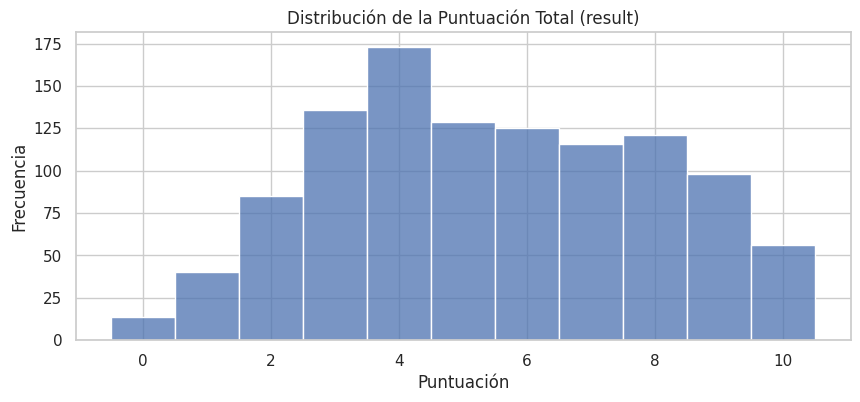

In [38]:
# Celda de Código 8: Configuración de Estilo y Análisis Univariado (Edad, Result)
print("\n--- Iniciando Paso 4: Análisis Exploratorio de Datos (EDA) ---")
sns.set_theme(style="whitegrid")
print("Estilo de gráficos Seaborn configurado.")

print("\n--- 4.1 Análisis Univariado ---")

# Edad General
print("\n**Distribución General de Edad**")
plt.figure(figsize=(10, 4))
sns.histplot(data=df_limpio, x='age', kde=True, bins=30)
plt.title('Distribución General de Edad')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.show() # Muestra el gráfico en Colab

# Edad por Grupo
print("\n**Distribución de Edad por Grupo**")
plt.figure(figsize=(10, 4))
sns.histplot(data=df_limpio, x='age', hue='grupo_edad', kde=True, element="step")
plt.title('Distribución de Edad por Grupo')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.show()

# Puntuación Total 'result'
print("\n**Distribución de la Puntuación Total (result)**")
plt.figure(figsize=(10, 4))
sns.histplot(data=df_limpio, x='result', discrete=True, kde=False)
plt.title('Distribución de la Puntuación Total (result)')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.show()


**Distribución de Casos ASD (Class_ASD)**


/tmp/ipython-input-1954126975.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




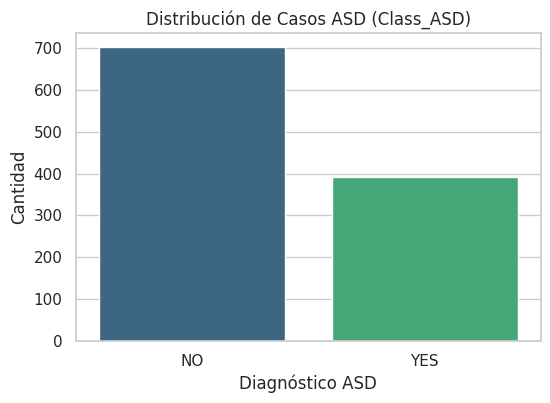


**Distribución por Género**


/tmp/ipython-input-1954126975.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




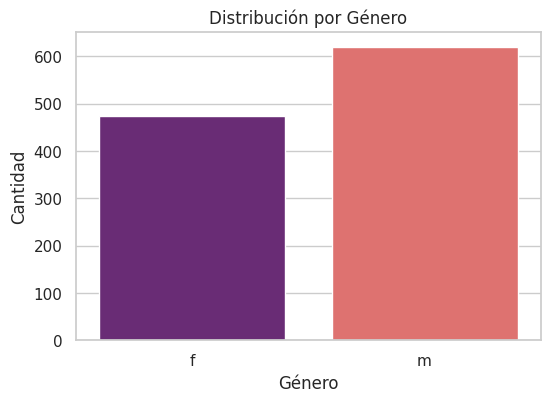

In [39]:
# Celda de Código 9: Análisis Univariado (Categóricas: ASD, Género)
# Diagnóstico 'Class_ASD'
print("\n**Distribución de Casos ASD (Class_ASD)**")
plt.figure(figsize=(6, 4))
asd_labels_plt = df_limpio['Class_ASD'].map({0: 'NO', 1: 'YES'})
sns.countplot(x=asd_labels_plt, palette="viridis", order=['NO', 'YES'])
plt.title('Distribución de Casos ASD (Class_ASD)')
plt.xlabel('Diagnóstico ASD')
plt.ylabel('Cantidad')
plt.show()

# Género
print("\n**Distribución por Género**")
plt.figure(figsize=(6, 4))
sns.countplot(data=df_limpio, x='gender', palette="magma")
plt.title('Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

### 4.2 Análisis Bivariado

Buscamos relaciones entre pares de variables.

In [40]:
# Celda de Código 10: Análisis Bivariado (Edad vs Result - Plotly Interactivo)
print("\n--- 4.2 Análisis Bivariado ---")
print("\n**Edad vs. Puntuación Total (Coloreado por ASD)**")
# Usamos Plotly Express para un gráfico interactivo
fig_edad_result_plotly = px.scatter(df_limpio, x='age', y='result',
                                    color=df_limpio['Class_ASD'].map({0: 'NO', 1: 'YES'}),
                                    title='Edad vs. Puntuación Total',
                                    labels={'age': 'Edad (años)', 'result': 'Puntuación', 'color': 'ASD'},
                                    hover_data=['grupo_edad', 'gender'], # Muestra info extra al pasar el ratón
                                    color_discrete_map={'NO': 'blue', 'YES': 'red'}) # Asignar colores
fig_edad_result_plotly.show() # Muestra el gráfico interactivo en Colab


--- 4.2 Análisis Bivariado ---

**Edad vs. Puntuación Total (Coloreado por ASD)**



**Puntuación Total por Diagnóstico ASD**


/tmp/ipython-input-63527058.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




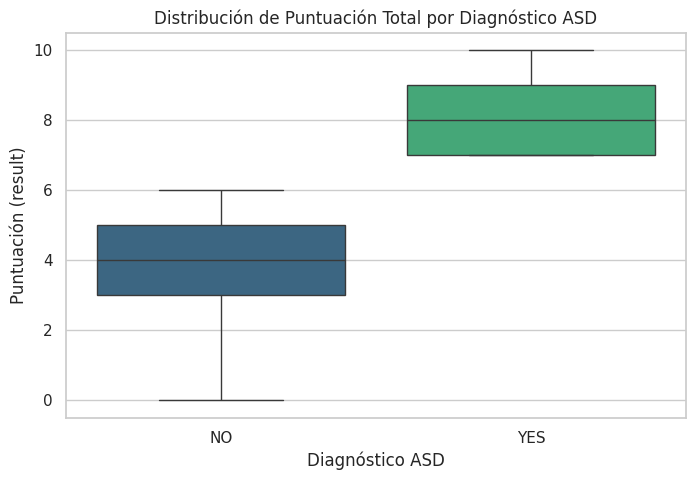


**Diagnóstico ASD por Género**


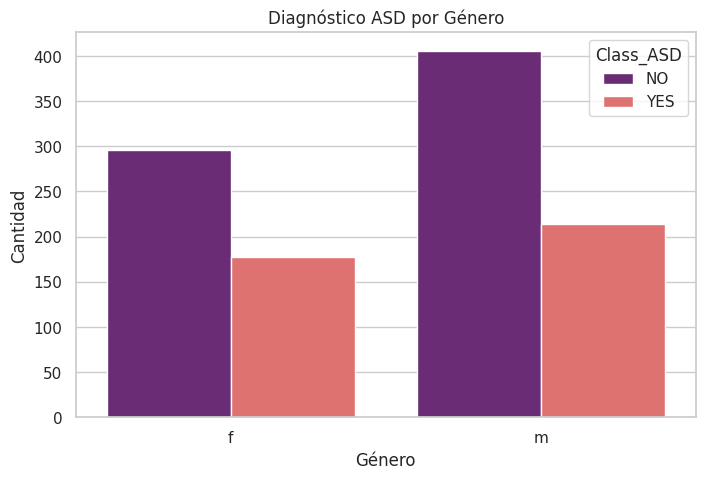

In [41]:
# Celda de Código 11: Análisis Bivariado (Resultado vs ASD, Género vs ASD)
# Resultado vs Diagnóstico
print("\n**Puntuación Total por Diagnóstico ASD**")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_limpio, x=asd_labels_plt, y='result', palette="viridis", order=['NO', 'YES'])
plt.title('Distribución de Puntuación Total por Diagnóstico ASD')
plt.xlabel('Diagnóstico ASD')
plt.ylabel('Puntuación (result)')
plt.show()

# Género vs Diagnóstico
print("\n**Diagnóstico ASD por Género**")
plt.figure(figsize=(8, 5))
sns.countplot(data=df_limpio, x='gender', hue=asd_labels_plt, palette="magma")
plt.title('Diagnóstico ASD por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()


**Diagnóstico ASD por Grupo de Edad**


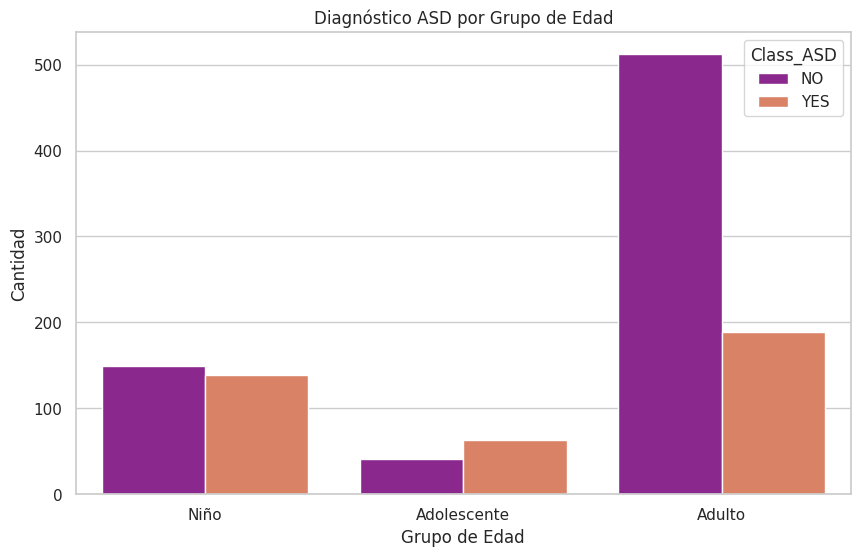


**Correlación entre Scores Individuales (A1-A10) y Resultado Total**


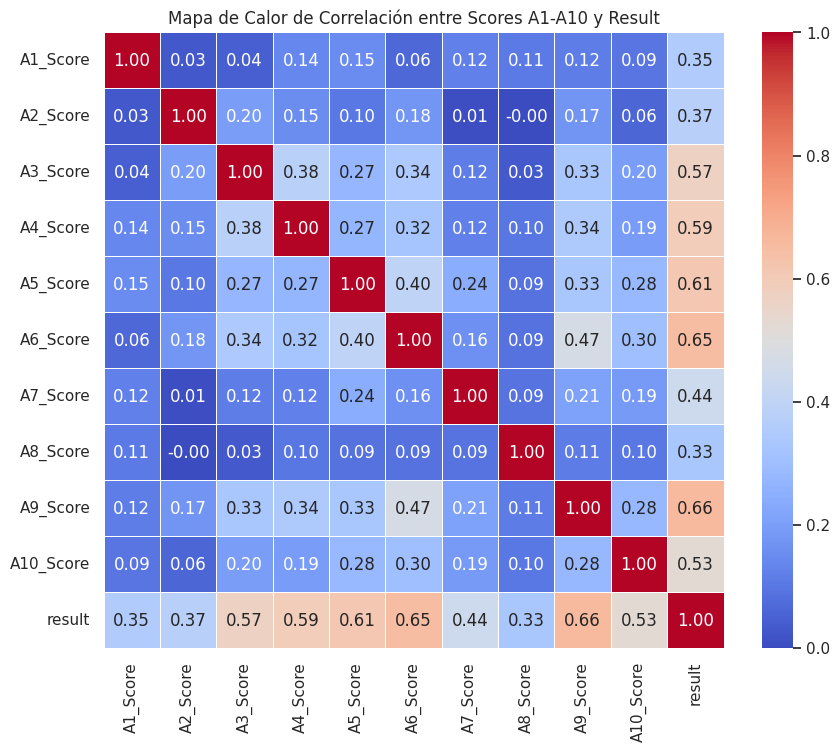

In [42]:
# Celda de Código 12: Análisis Bivariado (Grupo Edad vs ASD, Correlación Scores)
# Grupo Edad vs Diagnóstico 'Class_ASD'
print("\n**Diagnóstico ASD por Grupo de Edad**")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_limpio, x='grupo_edad', hue=asd_labels_plt, palette="plasma", order=['Niño', 'Adolescente', 'Adulto'])
plt.title('Diagnóstico ASD por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad')
plt.show()

# Correlación entre las puntuaciones A1-A10 y 'result'
print("\n**Correlación entre Scores Individuales (A1-A10) y Resultado Total**")
plt.figure(figsize=(10, 8))
columnas_scores_y_result = score_cols + ['result']
matriz_correlacion = df_limpio[columnas_scores_y_result].corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlación entre Scores A1-A10 y Result')
plt.show()

### 4.3 EDA Enfocado en Grupos de Edad

Visualizamos diferencias directas entre los grupos.


--- 4.3 EDA Enfocado en Grupos de Edad ---

**Comparación de Puntuación Total (result) por Grupo de Edad**


/tmp/ipython-input-1751334803.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




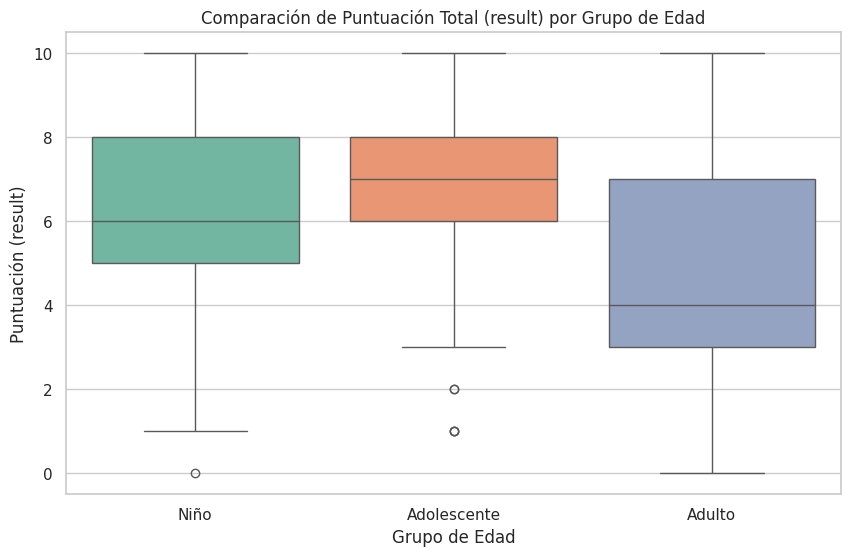


**Comparación de Ictericia al Nacer (jundice) por Grupo de Edad**


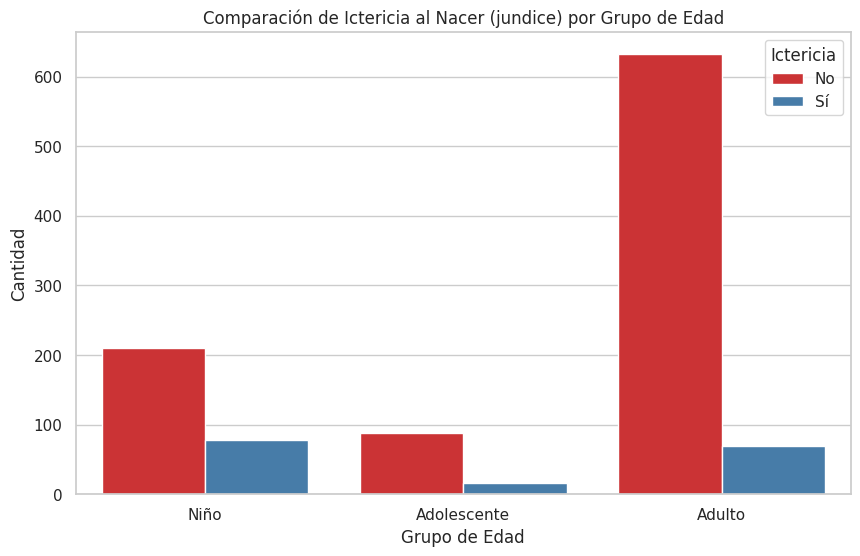


**Comparación de Antecedentes Familiares (autism_family_hist) por Grupo de Edad**


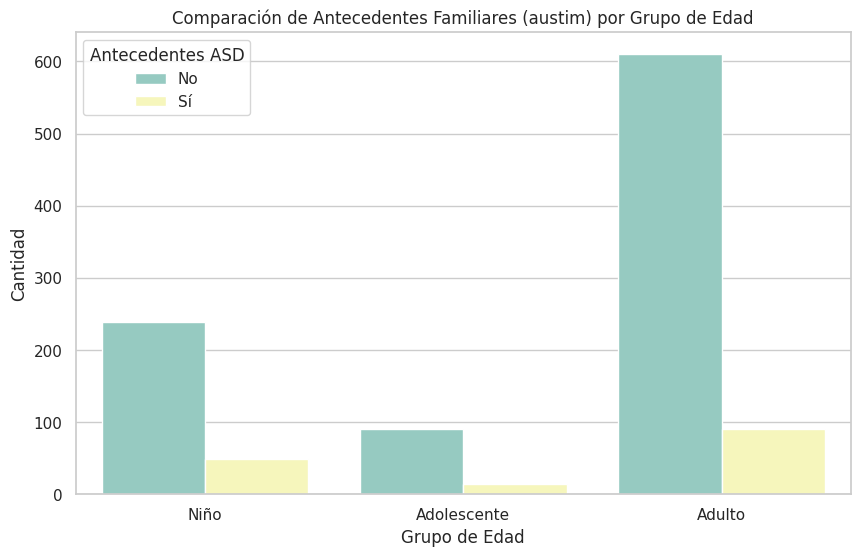


Análisis Exploratorio de Datos (EDA) completado.


In [43]:
# Celda de Código 13: EDA Enfocado en Grupos (Result, Jundice, Autism Hist)
print("\n--- 4.3 EDA Enfocado en Grupos de Edad ---")

# Comparación de 'result' entre Grupos
print("\n**Comparación de Puntuación Total (result) por Grupo de Edad**")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_limpio, x='grupo_edad', y='result', palette="Set2", order=['Niño', 'Adolescente', 'Adulto'])
plt.title('Comparación de Puntuación Total (result) por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Puntuación (result)')
plt.show()

# Comparación de 'jundice' entre Grupos
print("\n**Comparación de Ictericia al Nacer (jundice) por Grupo de Edad**")
jundice_labels_plt = df_limpio['jundice'].map({0: 'No', 1: 'Sí'})
plt.figure(figsize=(10, 6))
sns.countplot(data=df_limpio, x='grupo_edad', hue=jundice_labels_plt, palette="Set1", order=['Niño', 'Adolescente', 'Adulto'])
plt.title('Comparación de Ictericia al Nacer (jundice) por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad')
plt.legend(title='Ictericia')
plt.show()

# Comparación de 'autism_family_hist' entre Grupos
print("\n**Comparación de Antecedentes Familiares (autism_family_hist) por Grupo de Edad**")
austim_labels_plt = df_limpio['autism_family_hist'].map({0: 'No', 1: 'Sí'})
plt.figure(figsize=(10, 6))
sns.countplot(data=df_limpio, x='grupo_edad', hue=austim_labels_plt, palette="Set3", order=['Niño', 'Adolescente', 'Adulto'])
plt.title('Comparación de Antecedentes Familiares (austim) por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad')
plt.legend(title='Antecedentes ASD')
plt.show()

print("\nAnálisis Exploratorio de Datos (EDA) completado.")

## PASO 5: ANÁLISIS COMPARATIVO FORMAL ENTRE GRUPOS DE EDAD

Realizamos pruebas estadísticas para determinar si las diferencias observadas son significativas.


--- Iniciando Paso 5: Análisis Comparativo Formal ---

--- 5.1 Comparación Numérica ---

**Puntuación Total (result)**


/tmp/ipython-input-647431231.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




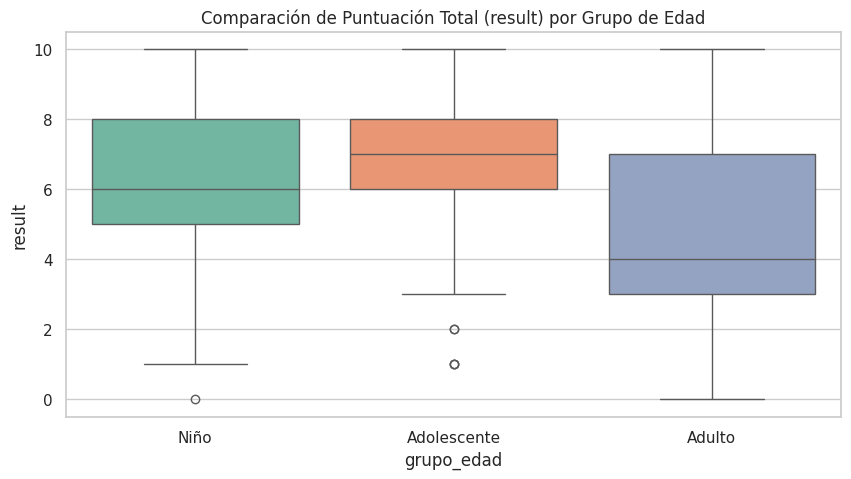


**Prueba Estadística (Kruskal-Wallis) para 'result':**
* Estadístico H: 94.771
* P-valor: 2.635e-21
-> Conclusión: Diferencias significativas en 'result' entre grupos (p < 0.05).


In [44]:
# Celda de Código 14: Comparación Numérica (Result) + Prueba Estadística
print("\n--- Iniciando Paso 5: Análisis Comparativo Formal ---")
print("\n--- 5.1 Comparación Numérica ---")
print("\n**Puntuación Total (result)**")

# Boxplot (ya mostrado en EDA, pero útil aquí también)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_limpio, x='grupo_edad', y='result', palette="Set2", order=['Niño', 'Adolescente', 'Adulto'])
plt.title('Comparación de Puntuación Total (result) por Grupo de Edad')
plt.show()

# Prueba Kruskal-Wallis
# H0: Las medianas de 'result' son iguales en los 3 grupos.
# H1: Al menos una mediana de 'result' es diferente.
stat_res, p_res = stats.kruskal(df_limpio[df_limpio['grupo_edad'] == 'Niño']['result'],
                                df_limpio[df_limpio['grupo_edad'] == 'Adolescente']['result'],
                                df_limpio[df_limpio['grupo_edad'] == 'Adulto']['result'])
print("\n**Prueba Estadística (Kruskal-Wallis) para 'result':**")
print(f"* Estadístico H: {stat_res:.3f}")
print(f"* P-valor: {p_res:.3e}")
if p_res < 0.05:
    print("-> Conclusión: Diferencias significativas en 'result' entre grupos (p < 0.05).")
else:
    print("-> Conclusión: No hay diferencias significativas en 'result' entre grupos (p >= 0.05).")

# Podríamos hacer lo mismo para 'age' pero es trivial.


--- 5.2 Comparación Categórica ---

**Diagnóstico ASD (Class_ASD)**

Tabla de Contingencia (Proporciones %):


Class_ASD,NO,YES
grupo_edad,,
Adolescente,39.4%,60.6%
Adulto,73.0%,27.0%
Niño,51.7%,48.3%


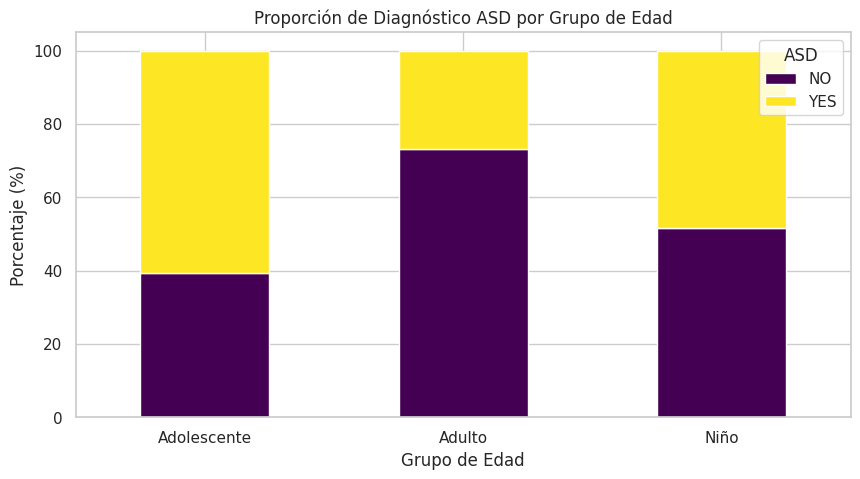


**Prueba Estadística (Chi-Cuadrado) para 'Class_ASD' vs 'grupo_edad':**
* Estadístico Chi2: 71.095
* P-valor: 3.648e-16
-> Conclusión: Asociación significativa entre grupo de edad y diagnóstico (p < 0.05).

**Ictericia al Nacer (jundice)**

Tabla de Contingencia (Proporciones %):


jundice,No,Sí
grupo_edad,,
Adolescente,84.6%,15.4%
Adulto,90.2%,9.8%
Niño,72.9%,27.1%



Análisis Comparativo Formal completado.


In [45]:
# Celda de Código 15: Comparación Categórica (Class_ASD) + Prueba Estadística
print("\n--- 5.2 Comparación Categórica ---")
print("\n**Diagnóstico ASD (Class_ASD)**")

# Tabla de contingencia (proporciones)
tabla_contingencia_asd = pd.crosstab(df_limpio['grupo_edad'], df_limpio['Class_ASD'].map({0:'NO', 1:'YES'}), normalize='index') * 100
print("\nTabla de Contingencia (Proporciones %):")
display(tabla_contingencia_asd.style.format("{:.1f}%"))

# Gráfico de barras apiladas porcentual
fig_comp_asd, ax_comp_asd = plt.subplots(figsize=(10, 5))
tabla_contingencia_asd.plot(kind='bar', stacked=True, ax=ax_comp_asd, colormap='viridis')
plt.title('Proporción de Diagnóstico ASD por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)
plt.legend(title='ASD')
plt.show()

# Prueba Chi-Cuadrado
# H0: No hay asociación entre grupo_edad y Class_ASD.
# H1: Hay asociación entre grupo_edad y Class_ASD.
contingencia_asd_abs = pd.crosstab(df_limpio['grupo_edad'], df_limpio['Class_ASD'])
chi2_asd, p_asd, dof_asd, expected_asd = stats.chi2_contingency(contingencia_asd_abs)
print("\n**Prueba Estadística (Chi-Cuadrado) para 'Class_ASD' vs 'grupo_edad':**")
print(f"* Estadístico Chi2: {chi2_asd:.3f}")
print(f"* P-valor: {p_asd:.3e}")
if p_asd < 0.05:
    print("-> Conclusión: Asociación significativa entre grupo de edad y diagnóstico (p < 0.05).")
else:
    print("-> Conclusión: No hay asociación significativa entre grupo de edad y diagnóstico (p >= 0.05).")

# Aquí se podrían añadir las pruebas y gráficos para Gender, Jundice, Autism_family_hist de forma similar...
# Para mantenerlo conciso, mostraremos solo la tabla de jundice como ejemplo adicional
print("\n**Ictericia al Nacer (jundice)**")
tabla_contingencia_jun = pd.crosstab(df_limpio['grupo_edad'], df_limpio['jundice'].map({0:'No', 1:'Sí'}), normalize='index') * 100
print("\nTabla de Contingencia (Proporciones %):")
display(tabla_contingencia_jun.style.format("{:.1f}%"))
# (Realizar prueba Chi2 si se desea evaluar significancia)

print("\nAnálisis Comparativo Formal completado.")

## PASO 6: MODELADO PREDICTIVO (BÁSICO)

Entrenamos un modelo simple de Regresión Logística para predecir `Class_ASD` como ejercicio demostrativo.

In [46]:
# Celda de Código 16: Preparación de Datos para Modelo
print("\n--- Iniciando Paso 6: Modelado Predictivo Básico ---")
print("\n--- 6.1 Preparación de Datos para el Modelo ---")

# Seleccionar características y objetivo
features = score_cols + ['age', 'jundice', 'autism_family_hist', 'gender']
target = 'Class_ASD'
df_modelo = df_limpio[features + [target]].copy()

# One-Hot Encode 'gender'
df_modelo = pd.get_dummies(df_modelo, columns=['gender'], drop_first=True, dtype=int)
print("Variable 'gender' convertida a numérica (One-Hot Encoding).")
print("Columnas resultantes:", df_modelo.columns.tolist())

# Verificar NaNs (importante antes de Sklearn)
if df_modelo.isnull().any().any():
     print("\nAdvertencia: Se detectaron NaNs inesperados en los datos del modelo. Eliminando filas afectadas.")
     df_modelo.dropna(inplace=True)

# Separar X e y
X = df_modelo.drop(columns=[target])
y = df_modelo[target]

print("\nCaracterísticas (X) para el modelo (primeras filas):")
display(X.head())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nDatos divididos: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba.")

# Escalar 'age'
cols_a_escalar = ['age']
scaler = StandardScaler()
X_train[cols_a_escalar] = scaler.fit_transform(X_train[cols_a_escalar])
X_test[cols_a_escalar] = scaler.transform(X_test[cols_a_escalar])
print("Variable 'age' escalada.")


--- Iniciando Paso 6: Modelado Predictivo Básico ---

--- 6.1 Preparación de Datos para el Modelo ---
Variable 'gender' convertida a numérica (One-Hot Encoding).
Columnas resultantes: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'jundice', 'autism_family_hist', 'Class_ASD', 'gender_m']

Características (X) para el modelo (primeras filas):


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,jundice,autism_family_hist,gender_m
0,1,1,0,0,1,1,0,1,0,0,6,0,0,1
1,1,1,0,0,1,1,0,1,0,0,6,0,0,1
2,1,1,0,0,0,1,1,1,0,0,6,0,0,1
3,0,1,0,0,1,1,0,0,0,1,5,1,0,0
4,1,1,1,1,1,1,1,1,1,1,5,1,0,1



Datos divididos: 874 entrenamiento, 219 prueba.
Variable 'age' escalada.



--- 6.2 Entrenamiento del Modelo ---
Modelo de Regresión Logística entrenado.

--- 6.3 Evaluación del Modelo ---

Accuracy (Precisión General) en datos de prueba: 100.00%

Matriz de Confusión:


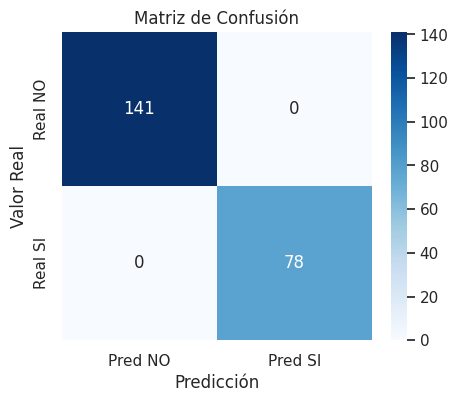


Informe de Clasificación:
              precision    recall  f1-score   support

  NO ASD (0)       1.00      1.00      1.00       141
  SI ASD (1)       1.00      1.00      1.00        78

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219


Modelado predictivo básico completado.


In [47]:
# Celda de Código 17: Entrenamiento y Evaluación del Modelo
print("\n--- 6.2 Entrenamiento del Modelo ---")
modelo = LogisticRegression(random_state=42, max_iter=1000)
modelo.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado.")

print("\n--- 6.3 Evaluación del Modelo ---")
y_pred = modelo.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['NO ASD (0)', 'SI ASD (1)'])

print(f"\nAccuracy (Precisión General) en datos de prueba: {accuracy:.2%}")

print("\nMatriz de Confusión:")
# Mostrar matriz de confusión visualmente
fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred NO', 'Pred SI'], yticklabels=['Real NO', 'Real SI'], ax=ax_cm)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

print("\nInforme de Clasificación:")
print(report)

print("\nModelado predictivo básico completado.")

In [48]:
porcentaje_positivos = (df_limpio['Class_ASD'].value_counts(normalize=True)[1] * 100)
print(f"Porcentaje de positivos ('YES'): {porcentaje_positivos:.1f}%")

Porcentaje de positivos ('YES'): 35.8%


In [49]:
# Tabla de contingencia (proporciones)
tabla_contingencia_asd = pd.crosstab(df_limpio['grupo_edad'], df_limpio['Class_ASD'].map({0:'NO', 1:'YES'}), normalize='index') * 100
print("\nTabla de Contingencia (Proporciones %):")
display(tabla_contingencia_asd.style.format("{:.1f}%"))

# ... (código para el gráfico de barras apiladas) ...


Tabla de Contingencia (Proporciones %):


Class_ASD,NO,YES
grupo_edad,,
Adolescente,39.4%,60.6%
Adulto,73.0%,27.0%
Niño,51.7%,48.3%


In [ ]:
print(f"Proporciones de 'YES': Niños {tabla_contingencia_asd.loc['Niño', 'YES']:.1f}%, Adolescentes {tabla_contingencia_asd.loc['Adolescente', 'YES']:.1f}%, Adultos {tabla_contingencia_asd.loc['Adulto', 'YES']:.1f}%")

In [50]:
tabla_contingencia_jundice = pd.crosstab(df_limpio['grupo_edad'], df_limpio['jundice'].map({0:'No', 1:'Sí'}), normalize='index') * 100
print("\nTabla de Contingencia para Jundice (Proporciones %):")
display(tabla_contingencia_jundice.style.format("{:.1f}%"))

# ... describe las diferencias en las proporciones de 'Sí' para jundice entre los grupos de edad ...


Tabla de Contingencia para Jundice (Proporciones %):


jundice,No,Sí
grupo_edad,,
Adolescente,84.6%,15.4%
Adulto,90.2%,9.8%
Niño,72.9%,27.1%


In [51]:
tabla_contingencia_hist_familiar = pd.crosstab(df_limpio['grupo_edad'], df_limpio['autism_family_hist'].map({0:'No', 1:'Sí'}), normalize='index') * 100
print("\nTabla de Contingencia para Historial Familiar de Autismo (Proporciones %):")
display(tabla_contingencia_hist_familiar.style.format("{:.1f}%"))


Tabla de Contingencia para Historial Familiar de Autismo (Proporciones %):


autism_family_hist,No,Sí
grupo_edad,,
Adolescente,86.5%,13.5%
Adulto,87.0%,13.0%
Niño,83.0%,17.0%


In [52]:
# Prueba Chi-Cuadrado para autism_family_hist vs grupo_edad
contingencia_hist_familiar_abs = pd.crosstab(df_limpio['grupo_edad'], df_limpio['autism_family_hist'])
chi2_hist_familiar, p_hist_familiar, dof_hist_familiar, expected_hist_familiar = stats.chi2_contingency(contingencia_hist_familiar_abs)

print("\n**Prueba Estadística (Chi-Cuadrado) para 'autism_family_hist' vs 'grupo_edad':**")
print(f"* Estadístico Chi2: {chi2_hist_familiar:.3f}")
print(f"* P-valor: {p_hist_familiar:.3e}")

if p_hist_familiar < 0.05:
    print("-> Conclusión: Asociación significativa entre grupo de edad e historial familiar de autismo (p < 0.05).")
else:
    print("-> Conclusión: No hay asociación significativa entre grupo de edad e historial familiar de autismo (p >= 0.05).")


**Prueba Estadística (Chi-Cuadrado) para 'autism_family_hist' vs 'grupo_edad':**
* Estadístico Chi2: 2.780
* P-valor: 2.491e-01
-> Conclusión: No hay asociación significativa entre grupo de edad e historial familiar de autismo (p >= 0.05).


In [53]:
# Prueba Chi-Cuadrado para jundice vs grupo_edad
contingencia_jundice_abs = pd.crosstab(df_limpio['grupo_edad'], df_limpio['jundice'])
chi2_jundice, p_jundice, dof_jundice, expected_jundice = stats.chi2_contingency(contingencia_jundice_abs)

print("\n**Prueba Estadística (Chi-Cuadrado) para 'jundice' vs 'grupo_edad':**")
print(f"* Estadístico Chi2: {chi2_jundice:.3f}")
print(f"* P-valor: {p_jundice:.3e}")

if p_jundice < 0.05:
    print("-> Conclusión: Asociación significativa entre grupo de edad e ictericia al nacer (p < 0.05).")
else:
    print("-> Conclusión: No hay asociación significativa entre grupo de edad e ictericia al nacer (p >= 0.05).")


**Prueba Estadística (Chi-Cuadrado) para 'jundice' vs 'grupo_edad':**
* Estadístico Chi2: 47.836
* P-valor: 4.098e-11
-> Conclusión: Asociación significativa entre grupo de edad e ictericia al nacer (p < 0.05).


### Descarga de Datos desde Repositorio

Descargamos los archivos CSV directamente desde el repositorio de GitHub.

In [ ]:
# Descargar datos_ninos.csv
!wget https://raw.githubusercontent.com/gedp/Analisis_de_datos_TEA/main/datos_ninos.csv

In [ ]:
# Descargar datos_adolescentes.csv
!wget https://raw.githubusercontent.com/gedp/Analisis_de_datos_TEA/main/datos_adolescentes.csv

In [ ]:
# Descargar datos_adultos.csv
!wget https://raw.githubusercontent.com/gedp/Analisis_de_datos_TEA/main/datos_adultos.csv

Ahora que los archivos han sido descargados, podemos proceder con la carga de datos.